# Аналитика данных компании Gectaro

**Цель проекта**  
  
Проанализировать имеющиеся данные, составить портреты наиболее типичных клиентов, разобраться в причинах оттока клиентов, предложить решения по их минимизации. Для этого предлагается определить ключевые признаки для компаний, наличие которых (или их появление) влияет на отмену (отсутствие оплаты) подписки.

## Загрузка данных и подготовка к анализу

### Загрузка библиотек

In [1]:
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import plotly.express as px
import math as mth
import scipy.stats as st
import warnings

Уберем ограничение по выводу строк, колонок и символов в записи и включаем игнорирование ошибок Jupiter.

In [2]:
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

#Игнорируем предупреждения Jupiter
warnings.filterwarnings('ignore')

Прописываем темы визуализации.

In [3]:
sns.set_style('darkgrid')
plt.style.use('ggplot')

### Загрузка данных

Запишем датафрейммы  activities.csv, billing.csv, companies.csv и people.csv в датасеты  activities, billing, companies и people соответственно.

In [4]:
try:
    activities, billing, companies, people = (
        pd.read_csv('data/activities.csv', index_col=0),
        pd.read_csv('data/billing.csv', index_col=0),
        pd.read_csv('data/companies.csv', index_col=0),
        pd.read_csv('data/people.csv', index_col=0)
    )


except:
    activities, billing, companies, people = (
        pd.read_csv('activities.csv', index_col=0),
        pd.read_csv('billing.csv', index_col=0),
        pd.read_csv('companies.csv', index_col=0),
        pd.read_csv('people.csv', index_col=0)
    )

Подготовим функцию для вывода информации о датафрейме.

In [5]:
def get_info(df):
    """
    Функция для вывода информации о датафрейме
    
    Args:
        df: датафрейм 
        
    Returns:
        print(информация о датафрейме)
        display(первые 5 строк датафрейма).
    """

    print(df.info())
    display(df.head())

Посмотрим информацию о датафреймах.

In [6]:
get_info(activities)

<class 'pandas.core.frame.DataFrame'>
Index: 6316 entries, 0 to 6556
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   company_id                     6316 non-null   int64  
 1   month                          6316 non-null   object 
 2   company-month-billing          6316 non-null   float64
 3   company-month-stocks           6316 non-null   float64
 4   company-month-backups          6316 non-null   float64
 5   company-month-projects         6316 non-null   float64
 6   company-month-contractors      6316 non-null   float64
 7   company-month-resource_orders  6316 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 444.1+ KB
None


,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


В нашем распоряжении **activities** датафрейм из 8 колонок и 6316 строк.
- `company_id` -  Идентификатор компании
- `month` -  Отчетный месяц
- `company-month-billing` -  Количество счетов, выставленных в приложении, компанией за месяц
- `company-month-stocks` -  Месячное количество складов (аренда, заказы и т.д.), используемых компанией
- `company-month-backups` -  Месячное количество бэкапов компании
- `company-month-projects` -  Месячное количество проектов компании
- `company-month-contractors` -  Месячное количество контрагентов компании
- `company-month-resource_orders` -  Месячное количество заказов материалов компании

In [7]:
get_info(billing)

<class 'pandas.core.frame.DataFrame'>
Index: 3480 entries, 4 to 18953
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               3480 non-null   int64  
 1   id                       3480 non-null   int64  
 2   user_id                  3480 non-null   int64  
 3   company_id               3480 non-null   int64  
 4   billing_tariff_id        3480 non-null   int64  
 5   payed_until              3480 non-null   int64  
 6   is_payed                 3480 non-null   bool   
 7   created_at               3480 non-null   int64  
 8   updated_at               3480 non-null   int64  
 9   billing_tariff_price_id  3480 non-null   float64
 10  comment                  745 non-null    object 
 11  pay_date                 1108 non-null   float64
dtypes: bool(1), float64(2), int64(8), object(1)
memory usage: 329.6+ KB
None


,Unnamed: 0,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
6,6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09
16,16,3059,1902,1645,2,1616577484,False,1608801484,1608801484,6.0,NaN,NaN
18,18,3065,2352,2035,7,1643500799,False,1608883175,1608883175,23.0,NaN,NaN
24,24,3062,1074,926,3,1611964800,True,1608814072,1608899674,9.0,NaN,1.609200e+09


В нашем распоряжении **billing** датафрейм из 12 колонок и 3480 строк.
- `Unnamed:0` - Старый индекс
- `id` - Неизвестная колонка
- `user_id` - Идентификатор пользователя
- `company_id` - Идентификатор компании пользователя
- `billing_tariff_id` - Тарифный план
- `payed_until` - Дата, до которой подписка компании действует
- `is_payed` - Статус оплаты
- `created_at` - Дата создания
- `updated_at` - Дата обновления
- `billing_tariff_price_id` - id стоимости тарифа
- `comment` - Комментарии
- `pay_date` - Дата платежа

In [8]:
get_info(companies)

<class 'pandas.core.frame.DataFrame'>
Index: 723 entries, 19 to 17972
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       723 non-null    int64  
 1   working_direction        720 non-null    object 
 2   employer_count_interval  723 non-null    float64
 3   created_at               723 non-null    int64  
 4   updated_at               723 non-null    int64  
 5   billing_tariff_id        716 non-null    float64
 6   billing_is_over          723 non-null    bool   
dtypes: bool(1), float64(2), int64(3), object(1)
memory usage: 40.2+ KB
None


,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
19,514,-,1.0,1571316635,1670298314,4.0,True
57,383,Строительство,2.0,1564142565,1676550050,7.0,False
69,495,-,1.0,1570535695,1598281714,2.0,False
75,724,-,1.0,1579514393,1670298294,4.0,True
99,471,-,1.0,1569328017,1670298360,7.0,True


В нашем распоряжении **companies** датафрейм из 7 колонок и 723 строк.
- `id` - id компании
- `working_direction` - сфера деятельности
- `employer_count_interval` - id количества сотрудников
- `created_at` - дата создания компании в системе
- `updated_at` - дата обновления информации о компании
- `billing_tariff_id` - id тарифа 
- `billing_is_over` - истекла ли оплата



In [9]:
get_info(people)

<class 'pandas.core.frame.DataFrame'>
Index: 5095 entries, 2 to 17054
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5095 non-null   int64  
 1   company_id  5095 non-null   int64  
 2   user_id     3813 non-null   float64
 3   role_id     5095 non-null   int64  
 4   created_at  5095 non-null   int64  
 5   updated_at  5095 non-null   int64  
 6   is_deleted  5095 non-null   bool   
 7   deleted_at  2180 non-null   float64
dtypes: bool(1), float64(2), int64(5)
memory usage: 323.4 KB
None


,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
2,6601,495,NaN,7133,1570535962,1570535962,True,1.594067e+09
6,7025,1,NaN,1,1594120484,1594120484,True,1.594120e+09
7,7165,1255,1734.0,18085,1595438102,1595439391,True,1.633960e+09
10,7130,1470,1703.0,1,1595234824,1595234824,False,NaN
17,7163,1492,1731.0,1,1595429211,1598540644,True,1.620195e+09


В нашем распоряжении **people** датафрейм из 8 колонок и 5095 строк.
 - `id`- индекс
 - `company_id`- id компании
 - `user_id`- id пользователя
 - `role_id`- id роли (должности)
 - `created_at`- дата создания пользователя
 - `updated_at`- дата обновления информации о пользователе
 - `is_deleted`- удален ли пользователь
 - `deleted_at`- дата удаления

Сохраним информацию о размерах датафреймов.

In [10]:
activities_start_shape = activities.shape
billing_start_shape = billing.shape
companies_start_shape = companies.shape
people_start_shape = people.shape

### Предобработка данных

#### Переименование столбцов

Приведем название столбцов в датафрейме **activities** к "змеиному регистру".

In [11]:
activities.columns = [re.sub('-', '_',  i) for i in activities.columns]
print(activities.columns)

Index(['company_id', 'month', 'company_month_billing', 'company_month_stocks',
       'company_month_backups', 'company_month_projects',
       'company_month_contractors', 'company_month_resource_orders'],
      dtype='object')


Переименование прошло успешно.

#### Удаление столбцов

Удалим столбец `Unnamed: 0` в датафрейме **billing**, т.к. он появился при формировании csv файла и содержит старые индексты.

In [12]:
billing = billing.drop(columns=['Unnamed: 0'])
print(billing.columns)

Index(['id', 'user_id', 'company_id', 'billing_tariff_id', 'payed_until',
       'is_payed', 'created_at', 'updated_at', 'billing_tariff_price_id',
       'comment', 'pay_date'],
      dtype='object')


Удаление прошло успешно.

#### Проверка на пропуски

Проверим датафреймы на пропуски.

In [13]:
activities.name = 'activities'
billing.name = 'billing'
companies.name = 'companies'
people.name = 'people'

for i in (activities, billing, companies, people):
    print(f'Пропусков в датафреме {i.name}')
    print(i.isna().sum())
    print()

Пропусков в датафреме activities
company_id                       0
month                            0
company_month_billing            0
company_month_stocks             0
company_month_backups            0
company_month_projects           0
company_month_contractors        0
company_month_resource_orders    0
dtype: int64

Пропусков в датафреме billing
id                            0
user_id                       0
company_id                    0
billing_tariff_id             0
payed_until                   0
is_payed                      0
created_at                    0
updated_at                    0
billing_tariff_price_id       0
comment                    2735
pay_date                   2372
dtype: int64

Пропусков в датафреме companies
id                         0
working_direction          3
employer_count_interval    0
created_at                 0
updated_at                 0
billing_tariff_id          7
billing_is_over            0
dtype: int64

Пропусков в датафреме people

В датафрейме **activities** нет пропусков.  
В датафрейме **billing** есть пропуски в колонках `comment` и `pay_date`, что логично, т.к. не ко всем счетам есть комментарии и не все счета оплачены.  
В датафрейме **companies** есть пропуски в колонках `working_direction` и `billing_tariff_id`, возможно, ответственный менеджер не внес информацию о свере дейстельности компании, а также, возможно, есть компании, которые не имеют подписок. Проверим это позже.  
В датафрейме **people** есть пропуски в колонце `user_id`, что странно, возможно, перепутаны колонки, и на самом деле id пользхователей находится в колонке `id`, посмотрим на это подробнее позже, а также есть пропуски в колонке `deleted_at`, что тоже логично, т.к. не все сотрудники удалены.

Посмотрим подробнее на датафрейм **companies**, а именно на строки с пропусками в колонке `billing_tariff_id`.

In [14]:
display(companies[companies['billing_tariff_id'].isna()])

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
1311,1394,ремонты,2.0,1594046967,1594046967,NaN,False
2207,2366,-,1.0,1605598351,1605598351,NaN,False
8311,7478,-,1.0,1678133266,1678133266,NaN,False
8313,7479,-,1.0,1678174074,1678174074,NaN,False
8315,7480,-,1.0,1678174873,1678174873,NaN,False
8317,7481,-,1.0,1678175908,1678175908,NaN,False
8885,7944,-,1.0,1684149633,1684149633,NaN,False


Мы видим, что пропуски в id тарифа у комапаний, у которых есть действующие подписки, без тарифов  информация об этих компаниях нам не поможет в анализе, удалим их.  
При этом, мы видим, что в сфере деятельности могут быть просто прочерки, посмотрим на строки с пропусками в этой колонке, и если не будет дополнительных замечаний, заменим их на тире. 

In [15]:
display(companies[companies['working_direction'].isna()])

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
2630,8364,NaN,2.0,1689327108,1692179928,2.0,False
6713,6927,NaN,1.0,1668598253,1709727143,17.0,False
8472,7527,NaN,2.0,1678794273,1686130137,9.0,False


Это действительно строки с пропускками только в одной строке, заполним их на тире.

In [16]:
companies['working_direction'] = companies['working_direction'].fillna('-')
print('Пропусков в колонке working_direction - ',  len(companies[companies['working_direction'].isna()]))

Пропусков в колонке working_direction -  0


Теперь посмотрим, сколько данных мы потеряем, когда удалим строки с пропусками в колонке `billing_tariff_id`.

In [17]:
clear_data = len(companies.dropna())

print(f'Потери данных: {(len(companies) - clear_data) / len(companies):.2%}')

Потери данных: 0.97%


Потери менее 1%, можем удалить эти строки.

In [18]:
companies = companies.dropna()
print('Строк с пропусками в датафрейме companies - ', companies.isna().sum().sum())

Строк с пропусками в датафрейме companies -  0


Посмотрим подробнее на датафрейм **people**, а именно, в каком проценте строк пропуски.

In [19]:
pd.DataFrame(round(people.isna().mean()*100,2))

,0
id,0.00
company_id,0.00
user_id,25.16
role_id,0.00
created_at,0.00
updated_at,0.00
is_deleted,0.00
deleted_at,57.21


Посмотрим, есть ли повторяющиесся значения в колонке `user_id`, без учета пропусков. А также на посотрим, есть ли дубли в колонке id.

In [20]:
print('Повторяющихся значений в колонке user_id - ', people[people['user_id'].notna()]['user_id'].duplicated().sum())
print('Повторяющихся значений в колонке id - ', people['id'].duplicated().sum())

Повторяющихся значений в колонке user_id -  285
Повторяющихся значений в колонке id -  0


Мы видим, что кроме 1282 пропусков в этой колонке еще 285 дублей. Возможно, если один человек работал сначала в оджной компании, а потом в другой, он оставался в базе с одним id, но был в рзных компангиях. При этом в колонке id нет пропусков и нет дублей, что все еще больше походит на настоящий user_id.  
Посмотрим на максимальное значение в колонке user_id, чтобы выбрать число дла замены.

In [21]:
print('Максимальное значение в колонке user_id - ', people['user_id'].max())

Максимальное значение в колонке user_id -  12992.0


т.к. максимальное знаение 12992, то мы заменим на 99999.

In [22]:
people['user_id'] = people['user_id'].fillna(99999)
print('Строк с пропусками в  колонке  user_id - ', people['user_id'].isna().sum())

Строк с пропусками в  колонке  user_id -  0


Заполнение пропусков прошло успешно.

#### Проверка на явные дубли

Проверим датафреймы на явные дубли.

In [23]:
activities.name = 'activities'
billing.name = 'billing'
companies.name = 'companies'
people.name = 'people'

for i in (activities, billing, companies, people):
    print(f'Явных дублей в датафреме {i.name} - {i.duplicated().sum()}')

Явных дублей в датафреме activities - 0
Явных дублей в датафреме billing - 0
Явных дублей в датафреме companies - 0
Явных дублей в датафреме people - 0


Явных дублей в датафрейме нет.

#### Проверка на неявные дубли

Проверим даатфреймы на наличие неявных дублей.  
Для начала посмотрим на датафрейм **activities**, в нем нас интересует только один столбец - `month`, т.к. остальные столбцы или id, или количественные показатели.

In [24]:
print('Количесво уникальных значений в столбце month - ', activities['month'].nunique())
print('Самый ранний месяц - ', activities['month'].min())
print('Самый поздний месяц - ', activities['month'].max())

Количесво уникальных значений в столбце month -  63
Самый ранний месяц -  2019-01-01 00:00:00+00:00
Самый поздний месяц -  2024-03-01 00:00:00+00:00


Как мы видим, в столбце данные с января 2019 года по март 2024 года, а это как раз 63 месяца. 

Датафрейм **billing** - в нем мы проверим столбец `billing_tariff_id`.

In [25]:
print('Уникальные тарифы в колонке billing_tariff_id - ', np.sort(billing['billing_tariff_id'].unique()))

Уникальные тарифы в колонке billing_tariff_id -  [ 2  3  4  6  7  9 10 11 13 17 19 20 21]


Мы видим, что из указанных в ТЗ тарифов у нас отсутствует тариф 8, но неизвестных тарифов нет.  Неявных дублей нет.

Датафрейм **companies** - в нем мы проверим столбец `working_direction`.

In [26]:
np.sort(companies['working_direction'].unique())

array(['-', '- чистовая отделка квартир', '-Инженерные системы',
       '-Малоэтажное строительство', '-Отделочные работы МОП, ТЦ, Офисы',
       '-Ремонт', '-Ремонт под ключ', '-Строительство и ремонт',
       '-Строительство, продажа стройматериалов',
       '-малоэтажное строительство', '-ремонт',
       '-строительно-монтажное направление. электроснабжение электрификация . ',
       '-строительство', '-строительство ', 'it',
       'Агрегатор элитных ремонтов', 'Архитектура Строительство',
       'Вентиляция Кондиционирование', 'Внутренние Инженерные системы',
       'Внутренние отделочные работы', 'Водоподготовка',
       'Генеральный подряд', 'Генеральный подрядчик', 'Генподряд',
       'Гидроизоляция, ремонт, строительство', 'Дарить людям радость',
       'Девелопмент', 'Демонтажные работы', 'Деревья',
       'Дизайн интерьеров', 'Дизайн, отделка, мебель',
       'Дома для хорошей жизни', 'Загородное строительство',
       'Изготовление заборов', 'Инвестиционно-строительная комп

Как и ожидалось, основная часть клиентов занимается строительством. Мы видим большое количество разных видов строителства, ремонта, отделки и проектирования в этой колонке.  
Возможно едобнее было бы делить кампании на созданнеы заранее категории, для удобства сегментирования.  
Попробуем поделить компании на категории самостоятельно:  
строительство, ремонт, отделка, noinfo и другое.

In [27]:
def working_direction_cat(cell_value):
    #проверяем, содержит ли ячейка строит или строй и возвращаем строительство
    if 'строит' in str(cell_value).lower() or 'строй' in str(cell_value).lower():
        return 'строительство'    
    #проверяем, содержит ли ячейка ремонт и возвращаем ремонт
    elif 'ремонт' in str(cell_value).lower() :
        return 'ремонт'    
    #проверяем, содержит ли ячейка отдел и возвращаем отделка
    elif 'отдел' in str(cell_value).lower() :
        return 'отделка'  
      #проверяем, содержит ли ячейка ремонт и возвращаем ремонт
    elif '-' in str(cell_value).lower() :
        return 'noinfo'  
    #в остальных случаях возвращаем другое
    else:
        return  'другое'

In [28]:
companies['working_cat'] = companies['working_direction'].apply(working_direction_cat)
print(companies['working_cat'].value_counts())

working_cat
noinfo           456
строительство    181
другое            45
ремонт            25
отделка            9
Name: count, dtype: int64


Мы видим, что у большей части компаний не была указана сфера деятельности, а из оставшихся кампаний большая часть занимается строительством.

Датафрйем **people** мы не будем проверять на неявные дубли, т.к. он состоит из численных значений.

#### Преобразование форматов данных

Для дальнейшей работы приведем форматы данных к удобному типу.

Для датафрейма **activities** колонку `month` приведем к формату datetime64, а оставшиеся колонки приведем к формату int, т.к. они содержат только целочисленные значения.

In [29]:
for i in activities.columns:
    if i == 'month':
        activities[i] = pd.to_datetime(activities[i], format='%Y-%m-%d %H:%M:%S%z')
    else:
        activities[i] = activities[i].astype('int')

print(activities.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6316 entries, 0 to 6556
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   company_id                     6316 non-null   int64              
 1   month                          6316 non-null   datetime64[ns, UTC]
 2   company_month_billing          6316 non-null   int64              
 3   company_month_stocks           6316 non-null   int64              
 4   company_month_backups          6316 non-null   int64              
 5   company_month_projects         6316 non-null   int64              
 6   company_month_contractors      6316 non-null   int64              
 7   company_month_resource_orders  6316 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(7)
memory usage: 444.1 KB
None


Предобразование прошло успешно.

В датафрейме **billing** мы изменим тип данных у колонки `billing_tariff_price_id` на int, т.к. она содержит только целые числа, а колонки `payed_until`, `created_at`, `updated_at` и `pay_date` из формата UNIX приведем к формату даты datetime64.

In [30]:
for i in ('billing_tariff_price_id', 'payed_until', 'created_at', 'updated_at', 'pay_date'):
    if i == 'billing_tariff_price_id':
        billing[i] = billing[i].astype('int')
    else:
        billing[i] = pd.to_datetime(billing[i],unit='s')

print(billing.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3480 entries, 4 to 18953
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       3480 non-null   int64         
 1   user_id                  3480 non-null   int64         
 2   company_id               3480 non-null   int64         
 3   billing_tariff_id        3480 non-null   int64         
 4   payed_until              3480 non-null   datetime64[ns]
 5   is_payed                 3480 non-null   bool          
 6   created_at               3480 non-null   datetime64[ns]
 7   updated_at               3480 non-null   datetime64[ns]
 8   billing_tariff_price_id  3480 non-null   int64         
 9   comment                  745 non-null    object        
 10  pay_date                 1108 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](4), int64(5), object(1)
memory usage: 302.5+ KB
None


Предобразование прошло успешно.

В датафрейме **companies** мы изменим тип данных у колонок  `employer_count_interval` и `billing_tariff_id` на int, т.к. они содержит только целые числа, а колонки `created_at` и `updated_at` из формата UNIX приведем к формату даты datetime64.

In [31]:
for i in ('employer_count_interval', 'created_at', 'updated_at', 'billing_tariff_id'):
    if i == 'employer_count_interval' or i == 'billing_tariff_id':
        companies[i] = companies[i].astype('int')
    else:
        companies[i] = pd.to_datetime(companies[i],unit='s')

print(companies.info())

<class 'pandas.core.frame.DataFrame'>
Index: 716 entries, 19 to 17972
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       716 non-null    int64         
 1   working_direction        716 non-null    object        
 2   employer_count_interval  716 non-null    int64         
 3   created_at               716 non-null    datetime64[ns]
 4   updated_at               716 non-null    datetime64[ns]
 5   billing_tariff_id        716 non-null    int64         
 6   billing_is_over          716 non-null    bool          
 7   working_cat              716 non-null    object        
dtypes: bool(1), datetime64[ns](2), int64(3), object(2)
memory usage: 45.4+ KB
None


Предобразование прошло успешно.

В датафрейме **people** мы изменим тип данных у колонки  `user_id` на int, т.к. она содержит только целые числа, а колонки `created_at`, `updated_at` и `deleted_at` из формата UNIX приведем к формату даты datetime64.

In [32]:
for i in ('user_id', 'created_at', 'updated_at', 'deleted_at'):
    if i == 'user_id':
        people[i] = people[i].astype('int')
    else:
        people[i] = pd.to_datetime(people[i],unit='s')

print(people.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5095 entries, 2 to 17054
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5095 non-null   int64         
 1   company_id  5095 non-null   int64         
 2   user_id     5095 non-null   int64         
 3   role_id     5095 non-null   int64         
 4   created_at  5095 non-null   datetime64[ns]
 5   updated_at  5095 non-null   datetime64[ns]
 6   is_deleted  5095 non-null   bool          
 7   deleted_at  2180 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](3), int64(4)
memory usage: 323.4 KB
None


Предобразование прошло успешно.

**Вывод**  
Мы подготовили данные к анализу:

- переименовали столбцы и привели их к “змеиному регистру”,
- проверили на пропуски датафрейм,
- проверили на явные дубли и удалили неявные,
- привели форматы столбцов к удобному: столбцы с целыми числами к int, а столбцы с датой к формату datetime.

## Исследовательский анализ данных

Для данного анализа текущая дата явяется 28.03.2024.

In [33]:
current_date = pd.to_datetime('28.03.2024')
print(current_date)


2024-03-28 00:00:00


### Общий анализ компаний

Посмотрим, когда создавались в системе компании.  
Посчитаем, сколько компаний добавлялось каждый месяц, а также сколько всего компнаий было зарегистрировано на каждый месяц.

In [34]:
# добавим колонку с месяцем и годом добавления компании в систему
companies['created_year_month'] = pd.to_datetime(companies['created_at']).dt.strftime('%Y-%m')

In [35]:
# посчитаем сколько в каждую дату было  добавлено компаний.
companies_dimanic = companies.groupby(by='created_year_month').agg({'id':'count'}).reset_index().sort_values(by='created_year_month')
# посчитаем кумулятивную сумму, т.е. с накоплением
companies_dimanic['companies_cumsum'] = companies_dimanic['id'].cumsum()

# установим месяц и год, как индекс и переименуем колонку
companies_dimanic = companies_dimanic.set_index('created_year_month').rename(columns={'id':'companys_per_month'})
display(companies_dimanic.head(5))

,companys_per_month,companies_cumsum
created_year_month,,
2019-01,3,3
2019-02,2,5
2019-03,1,6
2019-04,1,7
2019-05,2,9


Визуализируем даннные.

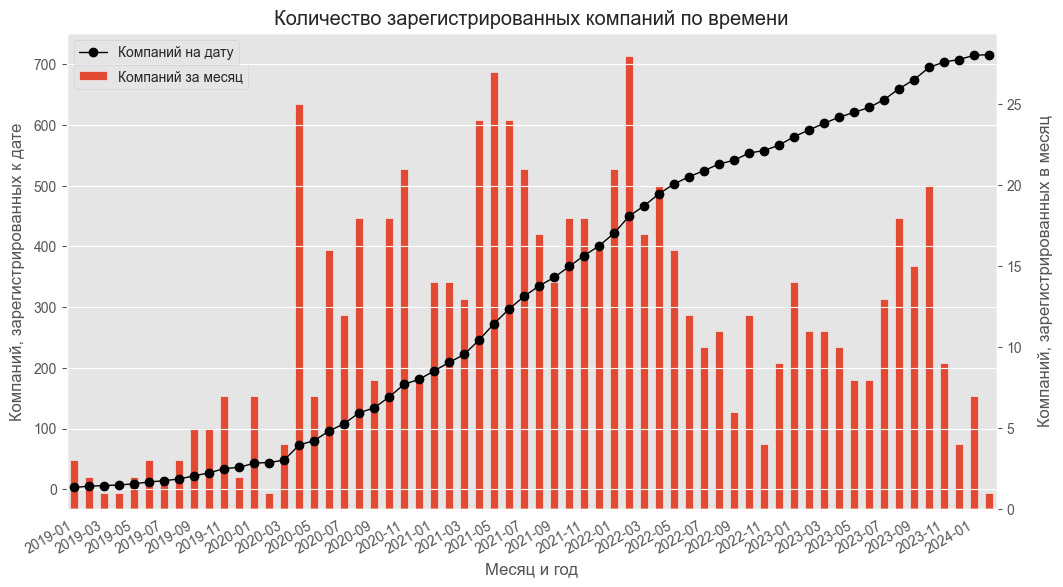

In [36]:
fig, ax = plt.subplots(figsize=(12, 7))

companies_dimanic[['companys_per_month']].plot(kind='bar', 
                               stacked=False, 
                               title='Количество зарегистрированных компаний по времени', 
                               ax=ax, 
                               grid=False)

ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), 
         companies_dimanic[['companies_cumsum']].values,  
         linestyle='-', 
         marker='o', 
         color='k', 
         linewidth=1.0, 
         label='Компаний на дату')

ax.set_xticklabels(companies_dimanic.index, fontsize=10)
ax.set_xlabel('Месяц и год')

ax.yaxis.set_ticks_position('right')
ax.set_ylabel('Компаний, зарегистрированных к дате', labelpad=30)


ax2.yaxis.set_ticks_position("left")
ax2.set_ylabel('Компаний, зарегистрированных в месяц', labelpad=30)

ax.legend(['Компаний за месяц'], loc='upper left', bbox_to_anchor=(0, 0.95))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1))

for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
fig.autofmt_xdate()
plt.show();

Мы видим, что большой, но нестабильный прирост компаний начался с мая 2020 года, а от 200 компаний в месяц начало регистрироваться с февраля 2021 года по сентябрь 2022 года.  
По графику можем предположить, что есть сезонность, рост регистраций компаний идет до лета, а минимум регистраций приходится на зиму.  Что логично, т.к. зимой, обычно, не начинают строить новые объекты, а делают только внетренние отделочные работы.

Посмотрим, компании с каким количество сотрудников больше всего зарегистрировано.

employer_count_interval
6      2
7      3
8      4
5      9
4     14
3     46
2    146
1    492
Name: count, dtype: int64



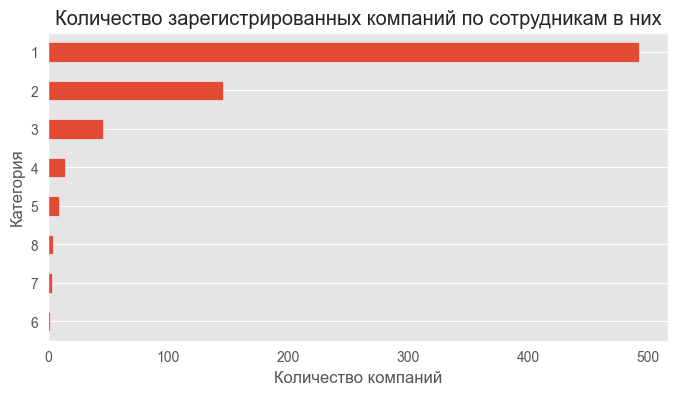

In [37]:
companies['employer_count_interval'].value_counts().sort_values().plot.barh(figsize=(8, 4))
plt.grid(axis='x')
plt.title('Количество зарегистрированных компаний по сотрудникам в них')
plt.xlabel('Количество компаний')
plt.ylabel('Категория');

print(companies['employer_count_interval'].value_counts().sort_values())
print()

Категории в таблице:  
- 1: 1-4 сотрудника,
- 2: 5-10 сотрудников, 
- 3: 11-20 сотрудников, 
- 4: 21-30 сотрудников, 
- 5: 31-50 сотрудников, 
- 6: 51-100 сотрудников, 
- 7: 101-200 сотрудников, 
- 8: >201 сотрудников.

Мы видим, что больше всего компаний с 1-4 сотрудниками, а меньше всего компаний с 51-100 сотрудниками.

billing_is_over
False    235
True     481
Name: count, dtype: int64



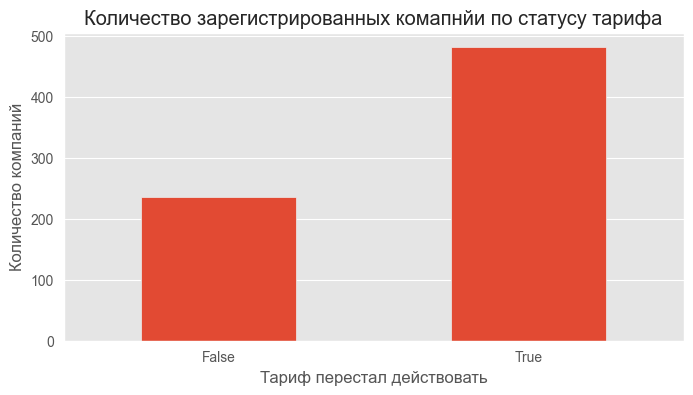

In [38]:
companies['billing_is_over'].value_counts().sort_values().plot.bar(figsize=(8, 4))
plt.grid(axis='x')
plt.title('Количество зарегистрированных комапнйи по статусу тарифа')
plt.xlabel('Тариф перестал действовать')
plt.xticks(rotation=0, ha='center')
plt.ylabel('Количество компаний');

print(companies['billing_is_over'].value_counts().sort_values())
print()

Мы видим, что у более чем половины зарегистрированных компаний тариф не действует.

Посмотрим, как распределены компании по оплате, в зависимости, платный ли у них тариф.  
Мы знаем, что бесплатные тарифы - это 1, 18 и 22.

In [39]:
free_plans =[1, 18, 22] 

In [40]:
def tariff_cat(cell_value):
    #проверяем, есть ли номериз ячейки в списке бесплатных тарифов, если да - возвращаем бесплатный тариф
    if cell_value in free_plans:
        return 'бесплатный тариф'     
    #в остальных случаях возвращаем платный тариф
    else:
        return  'платный тариф'

In [41]:
companies['tariff_cat'] = companies['billing_tariff_id'].apply(tariff_cat)
print(companies['tariff_cat'].value_counts())

tariff_cat
платный тариф    716
Name: count, dtype: int64


Мы видим, что в датафрейме companies у всех указаны платные тарифы, т.е. в эту базу не попали компании на тестовых или промо тарифах.

По комментариям заказчика, этот датафрейм не является точным при определении, оплачен ли тариф у комапнии.

Сформируем список компаний, которые имеют оплаченную подписку сейчас из датафрейма **billing**.  
Из проверки на неявные дубли мы знаем, что в датафрейме отсутствуют тарифы из бесплатной сетки.  Но можем проверить еще раз

In [42]:
print('Счетов с бесплатным тарифом в датафрейме billing - ', len(billing.query('billing_tariff_id in @free_plans')))

Счетов с бесплатным тарифом в датафрейме billing -  0


Теперь отберем компании и номер оплаченного тарифа, который является действующим на текущую дату.

In [43]:
paying_companies = billing.query('payed_until >= @current_date & is_payed == True')


Проверим, есть ли в нашем списке компании, у которых есть более одной действующей подписки.

In [44]:
temp = paying_companies.groupby(by='company_id', as_index=False)['billing_tariff_id'].count()
temp = temp.query('billing_tariff_id >1')
paying_companies.query('company_id in @temp.company_id')

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
8117,7840,7217,5591,2,2024-04-04,True,2022-03-30 06:53:23,2022-08-01 07:15:46,8,"04,04,22 активация 12+3м 04 07 2022 +3 месяца за кейс\r\n01 08 2022 +6 месяцев за видео кейс",2022-04-04 00:00:00
13450,13423,7217,5591,2,2026-02-04,True,2024-02-14 09:54:58,2024-02-21 09:13:30,24,"04,04,24- запуск тарифа 18+4",2024-02-21 09:13:30


У компании 5591 есть 2 оплаченные подписки, текущая подпсика заканчивается у них в этом месяце, поэтому они оплатили новую. Сохраним в список только id компании и номер тарифа.

In [45]:
# сохраняем только id комапнии и тарифа
paying_companies = paying_companies[['company_id', 'billing_tariff_id']]

# убираем дубль компании 5591
paying_companies = paying_companies.drop_duplicates()

print('Платящих компаний с активной подпсикой - ', len(paying_companies))

Платящих компаний с активной подпсикой -  241


В датафрейме 241 компания, которая имеет оплаченную активную подписку.  
Выберем также комапнии, которые имеют активную подписку, но еще не оплатили ее.

In [46]:
active_companies = billing.query('payed_until >= @current_date & company_id not in @paying_companies.company_id')

Посмотрим, попадают ли в этот список компании несколько раз.

In [47]:
temp = active_companies.groupby(by='company_id', as_index=False)['billing_tariff_id'].count()
temp = temp.query('billing_tariff_id >1')
display(active_companies.query('company_id in @temp.company_id').sort_values(by='company_id').head())

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
204,3045,567,512,2,2026-01-05 23:59:59,False,2020-12-21 14:47:22,2020-12-21 14:47:22,1,NaN,NaT
346,3047,567,512,7,2033-04-10 23:59:59,False,2020-12-21 15:05:06,2020-12-21 15:05:06,23,NaN,NaT
1833,4063,567,512,2,2026-12-05 23:59:59,False,2021-05-11 07:32:19,2021-05-11 07:32:19,8,NaN,NaT
12770,12946,1458,1255,9,2024-12-14 00:00:00,False,2023-12-14 12:55:01,2023-12-14 12:55:09,29,NaN,NaT
13004,13044,1458,1255,9,2025-01-16 23:59:59,False,2023-12-29 12:47:26,2023-12-29 12:47:26,29,NaN,NaT


Да, есть такие компании. И мы видим, что у таких компаний даже разные тарифы в разное время. Возможно, они с менеджерами обсуждают, какой тариф им подойдет лучше всего, пробуютт разные варианты.  
Сохраним компании и тариф, счет на который обновляли им последним.

In [48]:
active_companies = (active_companies
                    .sort_values(by=['company_id', 'updated_at'])
                    .groupby(by='company_id', as_index=False)
                    .agg({'billing_tariff_id':'last'}))


In [49]:
print('Компаний с активной подпсикой но без оплаты - ', len(active_companies))

Компаний с активной подпсикой но без оплаты -  201


Также в датафрейме есть 201 компания с активной подпиской, но еще не оплативших.

И выберем компании, которые оплачивали ранее подписку, но теперь у них нет активной подписки, т.е. компании, которые ушли.

In [50]:
departed_companies = billing.query('is_payed == True \
                                   & company_id not in @paying_companies.company_id \
                                   & company_id not in @active_companies.company_id')

Т.к. компании могли иметь несколько разных подписок за все время, сохнаим только последнюю оплаченную подписку, т.е. с которой компания ушла.

In [51]:
departed_companies = (departed_companies.sort_values(by=['company_id', 'pay_date'])
                    .groupby(by='company_id', as_index=False)
                    .agg({'billing_tariff_id':'last'}))

In [52]:
print('Компании, которые платили ранее, но теперь ушли - ', len(departed_companies))

Компании, которые платили ранее, но теперь ушли -  505


И сохраним список компаний,которые никогда не платили за подписку, но при этом пробовали ее.

In [53]:
tried_companies =  (billing.query('company_id not in @paying_companies.company_id \
                                   & company_id not in @active_companies.company_id \
                                   & company_id not in @departed_companies.company_id')
                                   .sort_values(by=['company_id', 'updated_at'])
                                   .groupby(by='company_id', as_index=False)
                                   .agg({'billing_tariff_id':'last'}))

In [54]:
print('Компании, которые пробовали подписку, но не платили - ', len(tried_companies))

Компании, которые пробовали подписку, но не платили -  894


И у нас есть 894 компании, которые использовали продукт, но не платили.

Теперь объединим наши списки в один датафрейм, при этом прописав статус к каждой компании.

In [55]:
paying_companies['status'] = 'Пользуются и платят'
active_companies['status'] = 'Пользуются и НЕ платят'
departed_companies['status'] = 'Больше не пользуются и платили'
tried_companies['status'] = 'Больше не пользуются и НЕ платили'

status_companies = pd.concat([paying_companies, 
                              active_companies, 
                              departed_companies, 
                              tried_companies], ignore_index=True)


Проверим, что мы не потеряли строки при объединении.

In [56]:
print('Строк потеряли при объединении - ', (
    len(status_companies) - len(paying_companies) - len(active_companies) - len(departed_companies) - len(tried_companies)
    ))

Строк потеряли при объединении -  0


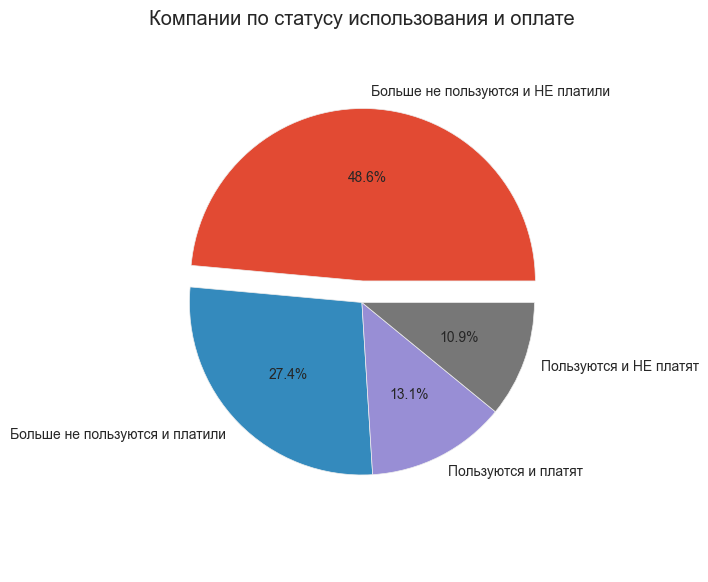

In [57]:
temp = status_companies.groupby(by='status', as_index=False)['company_id'].count().sort_values(by='company_id', ascending=False)

explode = (0.1, 0.0, 0.0, 0.0)

fig, ax = plt.subplots(figsize=(10, 7))

plt.pie(temp['company_id'], 
        labels = temp['status'], 
        autopct='%1.1f%%', 
        radius=0.8,
        explode=explode);
plt.title('Компании по статусу использования и оплате')

plt.show()

Мы видим, что почти половина (48,6%) компаний пробовали продукт, но так и не платили за подписку. 13,1% компаний пользуются сейчас оплаченной подпиской, а 10,9% еще не оплатили подписку, хотя используют ее.

### Общий анализ подписок

Посмотрим, с каких пользователи уходили чаще всего, а какими пользуются сейчас.  
Мы значем, что id тарифов делятся на 5 групп:  
- тарифы 4, 7, 8, 11, 19 - группа “старт”

- тарифы 2, 17 - группа “базовый”

- тарифы 9, 20 - группа “бизнес”

- тарифы 3, 10, 13, 21 - группа “Профи”

- тариф 6 - “архивный”, в настоящее время не используется


In [58]:
def tariff_group(cell_value):
    #проверяем, есть ли номериз ячейки в списке бесплатных тарифов, если да - возвращаем бесплатный тариф
    if cell_value in [4, 7, 8, 11, 19]:
        return 'старт' 
    elif cell_value in [2, 17]:
        return 'базовый'
    elif cell_value in [9, 20]:
        return 'бизнес'
    elif cell_value in [3, 10, 13, 21]:
        return 'профи'
    #в остальных случаях возвращаем платный тариф
    else:
        return  '“архивный”'
    
status_companies['tariff_group'] = status_companies['billing_tariff_id'].apply(tariff_group)
print(status_companies['tariff_group'].value_counts())

tariff_group
базовый       874
старт         721
бизнес        155
профи          82
“архивный”      9
Name: count, dtype: int64


Пользуются и платят
  tariff_group  company_id
0      базовый         126
1       бизнес          30
2        профи           9
3        старт          75
4   “архивный”           1

Пользуются и НЕ платят
  tariff_group  company_id
0      базовый          84
1       бизнес          26
2        профи          13
3        старт          78

Больше не пользуются и платили
  tariff_group  company_id
0      базовый         226
1       бизнес          20
2        профи          16
3        старт         236
4   “архивный”           7

Больше не пользуются и НЕ платили
  tariff_group  company_id
0      базовый         438
1       бизнес          79
2        профи          44
3        старт         332
4   “архивный”           1



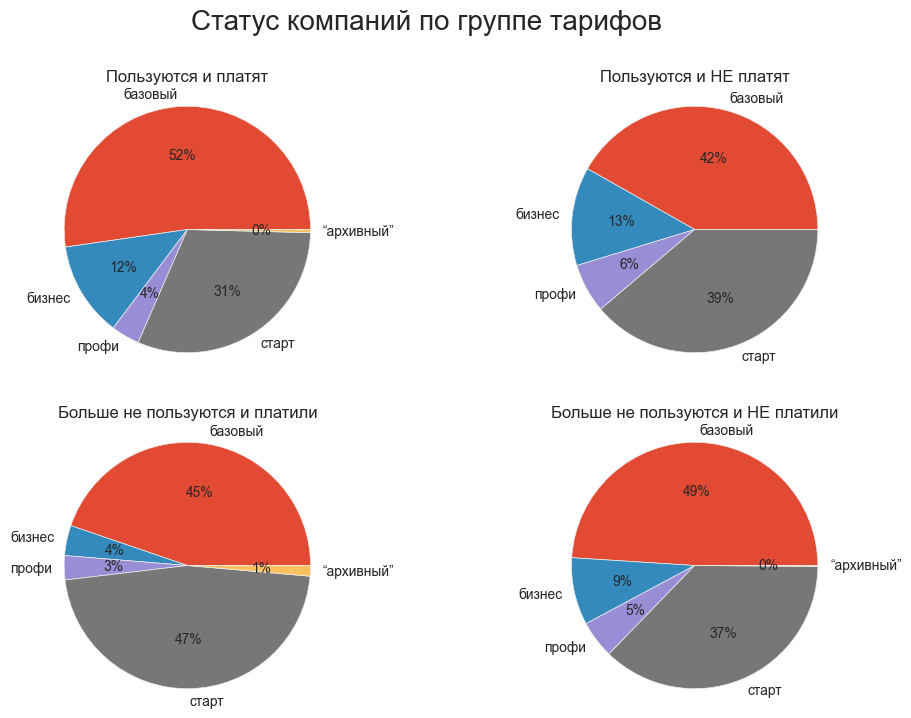

In [59]:

#задаем размеры общего графика
fig, ax = plt.subplots(2, 2, figsize=(12,8))

fig.suptitle('Статус компаний по группе тарифов', fontsize=20)

# подготовим индексы
plot_index_a = 0
plot_index_b = 0

#создаем круговую диаграмму для каждого статуса
for i in status_companies['status'].unique():
    temp = (status_companies
            .query('status == @i')
            .groupby('tariff_group', as_index=False)['company_id']
            .count()
            # сортируем по названиям, чтобы на графике каждая группа тарифа была одного цвета
            .sort_values(by='tariff_group'))
    ax[plot_index_a, plot_index_b].pie(temp['company_id'],
          labels=temp['tariff_group'],
          radius = 1.1,
          autopct='%.0f%%')
    ax[plot_index_a, plot_index_b].set_title(f'{i}', fontsize=12)

    if plot_index_a == 0 and plot_index_b == 0:
        plot_index_b = 1
    elif plot_index_a == 0 and plot_index_b == 1:
        plot_index_a = 1
        plot_index_b = 0
    else:
        plot_index_b = 1
    print(i)
    print(temp)
    print()

plt.show()

Мы видим, что для всех статусов компаний картина похожа, доли немного отличаются, возможно, в таких долях распределены все компании.  
Можем предположить, что комапниям больше нравится тарифы из бзовой группы, нежели из старта. И мы видим, что архивным тарифом пользовались компании, которые платили, а также до сих пор оплачивают.

### Анализ статуса компании по дате регистрации

Проанализируем, есть ли различия, между статусом компании и месяцем, когда она была зарегистрирована.  
Для этого к датафрейму **status_companies** присоединим часть датафрейма **companies**.  

Т.к. в датафреймах разное количество компаний, сделаем inner объединение, т.е. только по тем id, что встречаются в обоих датафреймах.

In [60]:
print('Количество уникальных компаний в billing - ', billing.company_id.nunique())
print('Количество уникальных компаний в companies - ', status_companies.company_id.nunique())
print('Количество уникальных компаний в companies - ', companies.id.nunique())


Количество уникальных компаний в billing -  1841
Количество уникальных компаний в companies -  1841
Количество уникальных компаний в companies -  716


In [61]:
status_companies = pd.merge(status_companies, companies[['id', 
                                                         'created_year_month', 
                                                         'created_at', 
                                                         'employer_count_interval']],  
                                                         left_on='company_id', 
                                                         right_on='id' , how='inner')
print('Новое количество уникальных компаний в companies - ', status_companies.company_id.nunique())

Новое количество уникальных компаний в companies -  716


In [62]:
temp = (status_companies
            .groupby(['status', 'created_year_month'], as_index=False)['company_id']
            .count())

fig = px.bar(temp, x="created_year_month", y="company_id", color="status")
fig.update_layout(
    title='Количество компаний по статусу и месяцу регистрации',
    xaxis=dict(
        title='Месяц регистрации',
        titlefont_size=16,
        tickfont_size=14,
    ),
    yaxis=dict(
        title='Количество компаний',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        title='Статус'))
fig.show()

Т.к. наиболее частый срок подписки 12-24 месяца мы видим, что как раз компании, которые от 1 до 2х лет назад пользуются подписками, но также мы видим, что почти нет компаний, которые пришли давно (более 3х лет назад) и пользуются продуктом до сих пор. 

### Анализ статуса компании по активности

Посмотрим, отличаются ли действия (и их количество) у компаний с разными статусами. 

In [63]:
company_activities = pd.merge(activities, 
                              status_companies[['company_id', 'status', 'tariff_group', 'created_at']], 
                              on='company_id', 
                              how='inner')
print('Строк было в датафрейме activities - ', len(activities))
print('Строк стало в датафрейме company_activities - ', len(company_activities))
display(company_activities.head())

Строк было в датафрейме activities -  6316
Строк стало в датафрейме company_activities -  6316


,company_id,month,company_month_billing,company_month_stocks,company_month_backups,company_month_projects,company_month_contractors,company_month_resource_orders,status,tariff_group,created_at
0,1,2019-09-01 00:00:00+00:00,1,0,0,7,0,0,Больше не пользуются и платили,профи,2019-01-23 14:00:51
1,1,2019-12-01 00:00:00+00:00,1,0,0,2,1,0,Больше не пользуются и платили,профи,2019-01-23 14:00:51
2,1,2020-04-01 00:00:00+00:00,4,1,0,1,6,0,Больше не пользуются и платили,профи,2019-01-23 14:00:51
3,1,2020-07-01 00:00:00+00:00,1,7,3,5,0,0,Больше не пользуются и платили,профи,2019-01-23 14:00:51
4,21,2020-01-01 00:00:00+00:00,3,0,0,1,0,0,Больше не пользуются и платили,старт,2019-01-31 13:03:23


Посчитаем, сколько месяцев прошло между добавлением компании в базу и ее действиями. Т.к. у нас нет точного времени действия, будем счиатать месяц, как 32 дня и брать только целую часть от полученного значения.  

In [64]:
# убираем часовой пояс
company_activities['month'] = company_activities['month'].map(lambda x: x.tz_localize(None))

# заменяем день на 1
company_activities['created_date'] = company_activities['created_at'].apply(lambda x: x.replace(day=1))

# применяем формат даты без времени
company_activities['created_date'] = company_activities['created_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

# приводим к datetime
company_activities['created_date'] = pd.to_datetime(company_activities['created_date'])

# считаем разницу между регистрацией и активностью
company_activities['months_after_registration'] = ((company_activities['month'] - company_activities['created_date']) 
                                                        / np.timedelta64 ( 32 , 'D')).astype('int')

Проверим, что посчиталось верно. 

In [65]:
display(company_activities[['company_id', 'month', 'created_at', 'created_date', 'months_after_registration']].head())
print('Минимум месяцев от регистрации до активности - ', company_activities.months_after_registration.min())
print('Максимум месяцев от регистрации до активности - ', company_activities.months_after_registration.max())

,company_id,month,created_at,created_date,months_after_registration
0,1,2019-09-01,2019-01-23 14:00:51,2019-01-01,7
1,1,2019-12-01,2019-01-23 14:00:51,2019-01-01,10
2,1,2020-04-01,2019-01-23 14:00:51,2019-01-01,14
3,1,2020-07-01,2019-01-23 14:00:51,2019-01-01,17
4,21,2020-01-01,2019-01-31 13:03:23,2019-01-01,11


Минимум месяцев от регистрации до активности -  0
Максимум месяцев от регистрации до активности -  49


Видим, что минимум 0, максимально - 49 месяцев (около 4х лет), все выглядит правдоподобно. И на первых 5 строках все даты посчитаны вернго.  
Посмотрим, по каким месяцам с даты регистрации у нас есть даннеы на компании с разным статусом.

In [66]:
for i in company_activities.status.unique():
    print(i)
    print(company_activities.query('status == @i')['months_after_registration'].describe())
    print()

Больше не пользуются и платили
count    3496.000000
mean        7.103833
std         7.664333
min         0.000000
25%         1.000000
50%         5.000000
75%        11.000000
max        49.000000
Name: months_after_registration, dtype: float64

Пользуются и платят
count    2480.000000
mean        9.682661
std         9.522764
min         0.000000
25%         2.000000
50%         7.000000
75%        15.000000
max        49.000000
Name: months_after_registration, dtype: float64

Пользуются и НЕ платят
count    340.000000
mean      12.985294
std       10.221576
min        0.000000
25%        4.000000
50%       12.000000
75%       19.000000
max       42.000000
Name: months_after_registration, dtype: float64



Поделим компании глобально на 2 категории: пользуются и ушли.

In [67]:
def global_status(cell_value):
    # песли статус Больше не пользуются и платили то присваиваем статус ушли
    if cell_value == 'Больше не пользуются и платили':
        return 'ушли'     
    #в остальных случаях возвращаем пользуются
    else:
        return  'пользуются'

In [68]:
company_activities['global_status'] = company_activities['status'].apply(global_status)
print(company_activities['global_status'].unique())

['ушли' 'пользуются']


Посмотрим, как во времени изменяется медианное количество действий у компаний на разных тарифах.

Сначала медианные значения.

In [69]:
for i in company_activities.global_status.unique():
    columns = ['company_month_billing',
               'company_month_stocks',
               'company_month_backups',
               'company_month_projects',
               'company_month_contractors',
               'company_month_resource_orders']
    temp = (company_activities
            .query('global_status == @i')
            .groupby(by=['tariff_group', 'months_after_registration'], as_index=False)[columns].median())
    fig = px.line(temp, x='months_after_registration', y=columns, color='tariff_group')
    fig.update_layout(
    title=f'Медианное количество действий по месяцам с даты регистрации, которые {i}',
        xaxis=dict(
                title='Месяцев с даты регистрации',
                titlefont_size=16,
                tickfont_size=14,
        ),
        yaxis=dict(
                title='Количество действий',
                titlefont_size=16,
                tickfont_size=14,
        ),
        legend=dict(
                title='Группа тарифов'))
    fig.show()

И посмотрим без разбивки на тарифы.

In [70]:
for i in company_activities.global_status.unique():
    columns = ['company_month_billing',
               'company_month_stocks',
               'company_month_backups',
               'company_month_projects',
               'company_month_contractors',
               'company_month_resource_orders']
    temp = (company_activities
            .query('global_status == @i')
            .groupby(by=['months_after_registration'], as_index=False)[columns].median())
    fig = px.line(temp, x='months_after_registration', y=columns)
    fig.update_layout(
    title=f'Медианное количество действий по месяцам с даты регистрации, которые {i}',
        xaxis=dict(
                title='Месяцев с даты регистрации',
                titlefont_size=16,
                tickfont_size=14,
        ),
        yaxis=dict(
                title='Количество действий',
                titlefont_size=16,
                tickfont_size=14,
        ),
        legend=dict(
                title='Группа тарифов'))
    fig.show()

И средние значения.

In [71]:
for i in company_activities.global_status.unique():
    columns = ['company_month_billing',
               'company_month_stocks',
               'company_month_backups',
               'company_month_projects',
               'company_month_contractors',
               'company_month_resource_orders']
    temp = (company_activities
            .query('global_status == @i')
            .groupby(by=['months_after_registration'], as_index=False)[columns].mean())
    fig = px.line(temp, x='months_after_registration', y=columns)
    fig.update_layout(
    title=f'Среднее количество действий по месяцам с даты регистрации, которые {i}',
        xaxis=dict(
                title='Месяцев с даты регистрации',
                titlefont_size=16,
                tickfont_size=14,
        ),
        yaxis=dict(
                title='Количество действий',
                titlefont_size=16,
                tickfont_size=14,
        ),
        legend=dict(
                title='Группа тарифов'))
    fig.show()

А также посмотрим на боксплоты действий для каждого года использования.

In [72]:
def get_year(cell_value):
    #проверяем, cколько месяцев использует компания продукт
    if cell_value <=12:
        #возвращаем год
        return 1   
    elif cell_value <=24:
        return 2  
    elif cell_value <=36:
        return 3  
    elif cell_value <=48:
        return 4  
    else:
        return  5

In [73]:
company_activities['years_after_registration'] = company_activities['months_after_registration'].apply(get_year)

In [74]:
columns = ['company_month_billing',
               'company_month_stocks',
               'company_month_backups',
               'company_month_projects',
               'company_month_contractors',
               'company_month_resource_orders']



for i in columns:
    fig = px.box(company_activities, x="years_after_registration", y=i, color="global_status")
    fig.update_traces(boxpoints=False, selector=dict(type='box'))
    fig.update_layout(
        title=f'Boxplot для действия {i}',
            xaxis=dict(
                    title='Лет с даты регистрации',
                    titlefont_size=16,
                    tickfont_size=14,
            ),
            yaxis=dict(
                    title='Количество действий',
                    titlefont_size=16,
                    tickfont_size=14,
            ),
            legend=dict(
                    title='Статус компании'))
    fig.show()


Выглядит так, что если компания на второй год использования увеличивает количество контракторов и количество заказов материаллов, то она продолжит использовать продукт.

### Корреляция параметров

Посмотрим, коррелируют ли активности компаний.

In [75]:
columns = [
               'months_after_registration',
               'company_month_billing',
               'company_month_stocks',
               'company_month_backups',
               'company_month_projects',
               'company_month_contractors',
               'company_month_resource_orders']
for i in company_activities.global_status.unique():
    print(f'Статус компании - {i}')
    display(pd.DataFrame(company_activities.query('global_status == @i')[columns].corr()).style.background_gradient('coolwarm'))
    print()

Статус компании - ушли


,months_after_registration,company_month_billing,company_month_stocks,company_month_backups,company_month_projects,company_month_contractors,company_month_resource_orders
months_after_registration,1.000000,-0.168075,-0.016787,0.111192,0.030430,-0.075157,-0.002754
company_month_billing,-0.168075,1.000000,0.072783,-0.104340,0.040101,0.048958,-0.050356
company_month_stocks,-0.016787,0.072783,1.000000,-0.006739,0.860060,0.181077,0.078329
company_month_backups,0.111192,-0.104340,-0.006739,1.000000,0.008711,-0.004285,0.072539
company_month_projects,0.030430,0.040101,0.860060,0.008711,1.000000,0.151196,0.115354
company_month_contractors,-0.075157,0.048958,0.181077,-0.004285,0.151196,1.000000,0.150585
company_month_resource_orders,-0.002754,-0.050356,0.078329,0.072539,0.115354,0.150585,1.000000



Статус компании - пользуются


,months_after_registration,company_month_billing,company_month_stocks,company_month_backups,company_month_projects,company_month_contractors,company_month_resource_orders
months_after_registration,1.000000,-0.187803,0.065459,0.104509,0.148543,-0.059737,0.096573
company_month_billing,-0.187803,1.000000,-0.048894,-0.094175,-0.075592,-0.000864,-0.048894
company_month_stocks,0.065459,-0.048894,1.000000,0.189281,0.812454,0.190585,0.276127
company_month_backups,0.104509,-0.094175,0.189281,1.000000,0.140972,0.034876,0.064904
company_month_projects,0.148543,-0.075592,0.812454,0.140972,1.000000,0.132167,0.313950
company_month_contractors,-0.059737,-0.000864,0.190585,0.034876,0.132167,1.000000,0.169160
company_month_resource_orders,0.096573,-0.048894,0.276127,0.064904,0.313950,0.169160,1.000000


Мы видим, что чем больше компания заводит проектов, тем больше она использует складов.  
А между компаниями, которые ушли или используют продукт - разницы в корреляциях практически нет.

**Вывод**  
Мы повели анализ данных.

- Большой, но нестабильный прирост компаний начался с мая 2020 года, а от 200 компаний в месяц начало регистрироваться с февраля 2021 года по сентябрь 2022 год.  
- Есть сезонность, рост регистраций компаний идет до лета, а минимум регистраций приходится на зиму.  Что логично, т.к. зимой, обычно, не начинают строить новые объекты, а делают только внетренние отделочные работы.
- Больше всего компаний с 1-4 сотрудниками, а меньше всего компаний с 51-100 сотрудниками.
- У более чем половины зарегистрированных компаний тариф не действует.
- Половина (48,6%) компаний пробовали продукт, но так и не платили за подписку. 13,1% компаний пользуются сейчас оплаченной подпиской, а 10,9% еще не оплатили подписку, хотя используют ее.
- Можем предположить, что комапниям больше нравится тарифы из бзовой группы, нежели из старта. И мы видим, что архивным тарифом пользовались компании, которые платили, а также до сих пор оплачивают.
- Т.к. наиболее частый срок подписки 12-24 месяца мы видим, что как раз компании, которые от 1 до 2х лет назад пользуются подписками, но также мы видим, что почти нет компаний, которые пришли давно (более 3х лет назад) и пользуются продуктом до сих пор. 
- Выглядит так, что если компания на второй год использования увеличивает количество контракторов и количество заказов материаллов, то она продолжит использовать продукт.
- Мы видим, что чем больше компания заводит проектов, тем больше она использует складов.  

## Проверка гипотез

### Зависимость уходов компаний от размера компании

Посмотрим, есть ли связь, между тем, малая компания (1-4 человека), или крупная (более 4 человек) и тем, уходят компании или нет.

подготовим функцию для присвоения категории компании по группе количества сотрудников.

In [76]:
def company_size(cell_value):
    # категория размера компании 1 возвращаем малая
    if cell_value == 1:
        return 'Малая'     
    #в остальных случаях возвращаем крупная
    else:
        return  'Крупная'

Применим функции.

In [77]:
status_companies['global_status'] = status_companies['status'].apply(global_status)
status_companies['company_size'] = status_companies['employer_count_interval'].apply(company_size)

Посмотрим, что функции применились.

In [78]:
display(status_companies.head())

,company_id,billing_tariff_id,status,tariff_group,id,created_year_month,created_at,employer_count_interval,global_status,company_size
0,4351,7,Пользуются и платят,старт,4351,2021-10,2021-10-05 11:34:59,1,пользуются,Малая
1,6288,7,Пользуются и платят,старт,6288,2022-06,2022-06-27 11:55:13,1,пользуются,Малая
2,4430,2,Пользуются и платят,базовый,4430,2021-10,2021-10-14 08:13:28,2,пользуются,Крупная
3,4883,2,Пользуются и платят,базовый,4883,2021-12,2021-12-16 16:29:10,1,пользуются,Малая
4,4517,9,Пользуются и платят,бизнес,4517,2021-10,2021-10-25 09:52:59,3,пользуются,Крупная


Подготовим функцию для проведения z-теста по сравнению долей.

In [79]:
def ztest(all_users_group_1, 
          all_users_group_2, 
          def_users_group_1,
          def_users_group_2, 
          alpha=0.05, 
          bonferrony=1):
    
    """
    Функция для проверки статистической разницы долей z-критерием
    
    Args:
        all_users_group_1 -  количество всех компаний группы 1,
        all_users_group_1 -  количество всех компаний группы 2,
        all_users_group_2 -  количество успешныйх компаний группы 1,
        def_users_group_2 -  количество успешныйх компаний  группы 1,
        alpha - критический уровень статистической значимости, по умолчанию 0.05
        bonferrony - поправка Бонферрони, по умолчанию 1
        
    Returns:
        print(доля оставшихся группы 1)
        print(доля оставшихся группы 2)
        print(p-значение и результат z-теста).
        
    """
    
    #делаем поправку значимости на коэффициент Бонферрони
    alpha = alpha / bonferrony
 
    
    #пропорция успехов в каждой группе
    p1 = def_users_group_1 / all_users_group_1
    p2 = def_users_group_2 / all_users_group_2
    
    #пропорция успехов в комбинированном датасете:
    p_combined = (def_users_group_1 + def_users_group_2) / (all_users_group_1 + all_users_group_2)
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1-p_combined) * (1/all_users_group_1 + 1/all_users_group_2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    #считаем p-значение для двухстороннего теста
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Доля оставшихся компаний группы 1', round(p1*100, 2))
    print(f'Доля оставшихся компаний группы 2', round(p2*100, 2))
    print('p-значение: ', p_value)
    
    if p_value < alpha: 
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Выдвенем нулевую гипотезу, что доли компаний, которые не ушли, равны.  
Альтернативная гипотеза: между долями есть значимая разница.
Коэффициент значимости выберем равным 0,05.

Подготовим группы для сравнения и применим функцию.

In [80]:
all_users_group_1 =  status_companies.query('company_size == "Малая"')['company_id'].nunique()
all_users_group_2 = status_companies.query('company_size == "Крупная"')['company_id'].nunique()

def_users_group_1 = status_companies.query('company_size == "Малая" & global_status == "пользуются"')['company_id'].nunique()
def_users_group_2 = status_companies.query('company_size == "Крупная" & global_status == "пользуются"')['company_id'].nunique()


ztest(all_users_group_1, 
          all_users_group_2, 
          def_users_group_1,
          def_users_group_2, 
          alpha=0.05, 
          bonferrony=1)

Доля оставшихся компаний группы 1 32.93
Доля оставшихся компаний группы 2 40.18
p-значение:  0.059585358672750166
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Нет оснований считать доли разными. Судя по всему компании из 1-4 человек уходят также часто, как и компании у которых более 4х сотрудников.

### Зависимость уходов компаний от тарифов

Посмотрим компаний каких тарифов у нас есть в достаточном количестве

In [81]:
status_companies.groupby('tariff_group')['company_id'].nunique()

tariff_group
базовый       324
бизнес         52
профи          23
старт         310
“архивный”      7
Name: company_id, dtype: int64

Как мы видим, только в тарифах базовый и старт есть несколько сотен компаний, в бизнесе 52, что может быть мало для сравнения, в тарифах профи иархивный еще меньше.

Выдвенем нулевую гипотезу, что доли компаний, которые не ушли, равны.  
Альтернативная гипотеза: между долями есть значимая разница.  
Коэффициент значимости выберем равным 0,05.

In [82]:
all_users_group_1 =  status_companies.query('tariff_group == "старт"')['company_id'].nunique()
all_users_group_2 = status_companies.query('tariff_group == "базовый"')['company_id'].nunique()

def_users_group_1 = status_companies.query('tariff_group == "старт" & global_status == "пользуются"')['company_id'].nunique()
def_users_group_2 = status_companies.query('tariff_group == "базовый" & global_status == "пользуются"')['company_id'].nunique()


ztest(all_users_group_1, 
          all_users_group_2, 
          def_users_group_1,
          def_users_group_2, 
          alpha=0.05, 
          bonferrony=1)

Доля оставшихся компаний группы 1 26.13
Доля оставшихся компаний группы 2 40.12
p-значение:  0.0001854752375813895
Отвергаем нулевую гипотезу: между долями есть значимая разница


Судя по всему между тарифами есть разница в долях ушедших пользователей. Скорее всего, с тарифа группы Старт уходят чаще, чем с группы Базовый.

### Зависимость уходов компаний от изменении цены

Чтобы нам посмотреть, вляет ли изменение цены на то, что компания останется, посчитаем для каждой компании уникальные id цены тарифа.

In [83]:
price_change = billing.groupby(by='company_id', as_index=False)['billing_tariff_id'].nunique()

Подготовим функцию для категоризации изменения цены:  если у компании был только один id цены, то считаем категорию цены стабильная, если нет - изменчивая.

In [84]:
def price_change_cat(cell_value):
    # категория размера компании 1 возвращаем Стабильная
    if cell_value == 1:
        return 'Стабильная'     
    #в остальных случаях возвращаем Изменчивая
    else:
        return  'Изменчивая'

Применим функцию.

In [85]:
price_change['price_change_cat'] = price_change['billing_tariff_id'].apply(price_change_cat)
display(price_change.head())

,company_id,billing_tariff_id,price_change_cat
0,1,1,Стабильная
1,5,5,Изменчивая
2,6,1,Стабильная
3,11,2,Изменчивая
4,13,2,Изменчивая


Объединим датафреймы.

In [86]:
print('Было строк в датафрейме status_companies',len(status_companies))
status_companies = pd.merge(status_companies, price_change[['company_id', 'price_change_cat']], on='company_id', how='left')
print('Стало строк в датафрейме status_companies',len(status_companies))
display(status_companies.head())

Было строк в датафрейме status_companies 716
Стало строк в датафрейме status_companies 716


,company_id,billing_tariff_id,status,tariff_group,id,created_year_month,created_at,employer_count_interval,global_status,company_size,price_change_cat
0,4351,7,Пользуются и платят,старт,4351,2021-10,2021-10-05 11:34:59,1,пользуются,Малая,Стабильная
1,6288,7,Пользуются и платят,старт,6288,2022-06,2022-06-27 11:55:13,1,пользуются,Малая,Стабильная
2,4430,2,Пользуются и платят,базовый,4430,2021-10,2021-10-14 08:13:28,2,пользуются,Крупная,Стабильная
3,4883,2,Пользуются и платят,базовый,4883,2021-12,2021-12-16 16:29:10,1,пользуются,Малая,Стабильная
4,4517,9,Пользуются и платят,бизнес,4517,2021-10,2021-10-25 09:52:59,3,пользуются,Крупная,Изменчивая


Посмотрим, сколько компаний у каждой категории.

In [87]:
display(status_companies.groupby('price_change_cat')['company_id'].nunique())

price_change_cat
Изменчивая    145
Стабильная    571
Name: company_id, dtype: int64

Выдвенем нулевую гипотезу, что доли компаний, которые не ушли, равны.  
Альтернативная гипотеза: между долями есть значимая разница.  
Коэффициент значимости выберем равным 0,05.

In [88]:
all_users_group_1 =  status_companies.query('price_change_cat == "Стабильная"')['company_id'].nunique()
all_users_group_2 = status_companies.query('price_change_cat == "Изменчивая"')['company_id'].nunique()

def_users_group_1 = status_companies.query('price_change_cat == "Стабильная" & global_status == "пользуются"')['company_id'].nunique()
def_users_group_2 = status_companies.query('price_change_cat == "Изменчивая" & global_status == "пользуются"')['company_id'].nunique()


ztest(all_users_group_1, 
          all_users_group_2, 
          def_users_group_1,
          def_users_group_2, 
          alpha=0.05, 
          bonferrony=1)

Доля оставшихся компаний группы 1 33.27
Доля оставшихся компаний группы 2 42.76
p-значение:  0.032729856437840654
Отвергаем нулевую гипотезу: между долями есть значимая разница


Судя по всему есть разница в долях ушедших пользователей. Скорее всего, с компании, цена на подписку у которых не менялась, остаются чаще.

**Вывод**  
Мы проверили гипотезы:  
- Судя по всему, компании из 1-4 человек уходят также часто, как и компании у которых более 4х сотрудников.
- Скорее всего, с тарифа группы Старт уходят чаще, чем с группы Базовый.
- Судя по всему, компании, цена на подписку у которых не менялась, остаются чаще.

## Выводы

Мы подготовили данные к анализу:


- переименовали столбцы и привели их к “змеиному регистру”,
- проверили на пропуски датафрейм,
- проверили на явные дубли и удалили неявные,
- привели форматы столбцов к удобному: столбцы с целыми числами к int, а столбцы с датой к формату datetime.


Мы повели анализ данных.


- Большой, но нестабильный прирост компаний начался с мая 2020 года, а от 200 компаний в месяц начало регистрироваться с февраля 2021 года по сентябрь 2022 год.  
- Есть сезонность, рост регистраций компаний идет до лета, а минимум регистраций приходится на зиму.  Что логично, т.к. зимой, обычно, не начинают строить новые объекты, а делают только внутренние отделочные работы.
- Больше всего компаний с 1-4 сотрудниками, а меньше всего компаний с 51-100 сотрудниками.
- У более чем половины зарегистрированных компаний тариф не действует.
- Половина (48,6%) компаний пробовали продукт, но так и не платили за подписку. 13,1% компаний пользуются сейчас оплаченной подпиской, а 10,9% еще не оплатили подписку, хотя используют ее.
- Можем предположить, что компаниям больше нравится тарифы из базовой группы, нежели из старта. И мы видим, что архивным тарифом пользовались компании, которые платили, а также до сих пор оплачивают.
- Т.к. наиболее частый срок подписки 12-24 месяца мы видим, что как раз компании, которые от 1 до 2х лет назад пользуются подписками, но также мы видим, что почти нет компаний, которые пришли давно (более 3х лет назад) и пользуются продуктом до сих пор. 
- Выглядит так, что если компания на второй год использования увеличивает количество контакторов и количество заказов материалов, то она продолжит использовать продукт.
- Мы видим, что чем больше компания заводит проектов, тем больше она использует складов.  


Мы проверили гипотезы:  
- Судя по всему, компании из 1-4 человек уходят также часто, как и компании у которых более 4х сотрудников.
- Скорее всего, с тарифа группы Старт уходят чаще, чем с группы Базовый.
- Судя по всему, компании, цена на подписку у которых не менялась, остаются чаще.

## Рекомендации

- У компании большая доля компаний, которые используют подписку, но еще не оплатили ее, работа с этой частью компаний может принести быструю прибыль.  
- У компании еще больше доля компаний, которые пробовали продукт, платили за него, но не стали продлевать подписку, возможно, если выяснить причину ухода, можно будет вернуть часть этих компаний.  
- Возможно, стоит исправить тариф Старт, т.к. с него уходят чаще всего.
- Для удержания клиента, судя по всему, стоит изменять цену подписки, если это требуется.
- Стоит следить за количеством контрактов и заказом материаллов, т.к. их уменьшение может быть сигналом, что компания уходит.